**Problem Set 2: Part 1**

---

*In this notebook, you will learn how to:*
- Download rainfall data using Google Earth Engine
- Work with time series data across multiple sites
- Explore how rainfall varies with location
 
To execute the code, click on a cell, then hit shift+enter. Follow along and write code to accomplish the tasks in the comments; you may need to modify existing code, or write new code.

If you see `### SOME COMMENT FROM ME ###` in a code block, that usually means you need to fill in some original code of your own. If I ask you to plot some data, make sure your plots are well labeled, with axes labels and a legend if necessary. 

# Import required libraries

In [ ]:
# Import required libraries. Must run this first
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import numpy as np
import seaborn as sns
%matplotlib inline



### Install new package *geemap* for geospatial visualization

Packages require installation, so you'll see quite a bit of 

In [ ]:
pip install geemap

# Import required libraries

In [ ]:
import geemap

# Initialize and authenticate Google Earth Engine

Signup for a Google Earth Engine account [HERE](https://signup.earthengine.google.com/#!/). 



In [ ]:
# Import the Earth Engine API and initialize it.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=fFqWIobRLKsw4wKLKTegBMfVOTJx9n-gqc3nvBrb6Rk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWi7uu5Gtn8XWsqhfaA4C-uMlOzQl9LDRNjiWa51HIShVad7nJ3dG3M

Successfully saved authorization token.


# Load your sites 



**Method 1:**
Manually input latitude, longitude, and names of your sites into these numpy arrays. 

*The sites listed below represent a collection of research sites in California where hydrologic monitoring data are available. Keep it in mind for your project...*

*Google maps is an easy way to get lat, lon for sites.*


In [ ]:
#we will create a list of longitute (lons), latitutes (lats), and names of sites (ids)
lons = np.array([-122.350  , -123.479   , -123.604 , -121.554, -119.204 ,-117.746 ])

lats = np.array([ 39.150    ,  39.564    ,  39.714  ,   39.802 ,37.054, 34.201 ])

ids = np.array([  'Antelope Valley Ranch (AVR)','Dry Creek','Elder Creek','Paradise, CA','KREW (P300 gauge)','San Dimas Experimental Watershed'])

numsites = len(lats)

In [ ]:
lons = np.array([-122.350  , -123.479  , -121.717963])
lats = np.array([ 39.150    ,  39.564   , 37.219076])
                
ids = np.array([  'Antelope Valley Ranch (AVR)', 'Coyote Ridge','Dry Creek'])
numsites = len(lats)

**Method 2:** 

You could create a transect that interpolates between two points. 

In [ ]:
#input a starting point
lat1 =  29.72
lon1 = -95.48

#input an ending point 
lat2 = 31.67 
lon2 = -106.08

#specify how many sites you want along your transect- this number should be small (<10 probably), because GEE will cut you off
numsites = 8

lats =  np.linspace(lat1, lat2, num=numsites, endpoint=True)
lons =  np.linspace(lon1, lon2, num=numsites, endpoint=True)

ids  = np.linspace(1,numsites,num=numsites,endpoint=True)


# Convert your list of sites into a Feature Collection and extract elevation for each site 

A Feature Collection is a GEE data type which you can think of as a group of vector data (think polygons, points, and lines), which GEE refers to as "features." Each feature in a collection has "properties." In this case we will set the 'id' to the property we are calling "Site."

We will then use a GEE "reducer" function to go from an image (such as a raster of elevation) to a set of values at our lat/lons. In this case we are using the function image.ReduceRegions because we want to "reduce" the image to just the points in our feature collection. You can explore the other possible inputs to the reduceRegions function [here](https://developers.google.com/earth-engine/apidocs/ee-image-reduceregion).

In [ ]:
# we will then create a google earth engine "feature collection" using this information
fts_list = []
for i in range(len(ids)):
  ft = ee.Feature(ee.Geometry.Point((lons[i],lats[i])))
  ft = ft.set({'Site':str(ids[i])})
  fts_list.append(ft)
sites = ee.FeatureCollection(fts_list)

In [ ]:
## function for extracting value from a raster via GEE, we will use it momentarily
def extract(image):
  val = image.reduceRegions(sites, ee.Reducer.mean())
  return val

In [ ]:
## extract elevation data for each point using the USGS STRM digital elevation model (DEM)
dem = ee.Image('USGS/SRTMGL1_003')
elevs = extract(dem)
sitesdict = elevs.getInfo()

In [ ]:
## let's make a list of elevations for the sites. Notice that the reduceRegions function added a new property ('mean') to each of our sites.
els=[]
for feat in sitesdict['features']:
  el=feat['properties']['mean']
  els.append(el)

In [ ]:
## here we will print out the lat lon and elevations for each site 
sitesdict = elevs.getInfo()
for feat in sitesdict['features']:
  print(feat['properties']['Site'])
  lon,lat,elev = feat['geometry']['coordinates'][0],feat['geometry']['coordinates'][1],feat['properties']['mean']
  print('\t Lon = %.3f, Lat = %.3f, Elev = %.3f'%(lon,lat,elev)) # the % symbols are for formatting the printed out strings. If this is new for you, you can read more about it here: https://www.w3schools.com/python/ref_string_format.asp. 

1.0
	 Lon = -95.480, Lat = 29.720, Elev = 27.000
2.0
	 Lon = -96.994, Lat = 29.999, Elev = 90.000
3.0
	 Lon = -98.509, Lat = 30.277, Elev = 382.000
4.0
	 Lon = -100.023, Lat = 30.556, Elev = 639.000
5.0
	 Lon = -101.537, Lat = 30.834, Elev = 782.000
6.0
	 Lon = -103.051, Lat = 31.113, Elev = 836.000
7.0
	 Lon = -104.566, Lat = 31.391, Elev = 1423.000
8.0
	 Lon = -106.080, Lat = 31.670, Elev = 1230.000


# If you'd like an interactive map with the location of your sites 

# Mapping method 1: 
[geemap](https://geemap.org/) is a package for visualizing geospatial data from GEE through complex interactive maps. This is a very simple example, but I encourage you to peruse geemap's web presence for well documented examples if you want to learn more.

In [ ]:
Map = geemap.Map(zoom = 4) #you can specify the zoom and starting centered coordinates
#Map.add_basemap('SATELLITE')
#Map.add_basemap('Esri Terrain') #there are many basemap options. Google to find more.

# Set visualization parameters.
vis_params = {'min': 0, 'max': 2000, 'dimensions': 512,
                'palette':['F5F5F5', 'D8D8D8', '662A00', 'E5FFCC', '006633']}

dat = ee.Image(ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").select('pr').reduce(ee.Reducer.mean()).multiply(ee.Number(12))) #this is mean annual precip
Map.addLayer(dat, vis_params, name = 'MAP (mm)', shown=True)


# Add feature collection of sites to the map
Map.addLayer(sites, {}, name = 'Transect sites')

# Add state borders to your map
states = ee.FeatureCollection('TIGER/2018/States')
style = {"color": "#bdbdbd", "width":3, "lineType":'solid', "fillColor":'00000000'}
Map.addLayer(states.style(**style), {}, 'US States')

Map.setControlVisibility()

Map

# Mapping method 2:
Folium is a different method for visualizing geospatial data within python. 
Uncomment the cell below to explore folium. 

In [ ]:
# import folium

# # Define a method for displaying Earth Engine image tiles to folium map.
# def add_ee_layer(self, ee_image_object, vis_params, name):
#   map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
#   folium.raster_layers.TileLayer(
#     tiles = map_id_dict['tile_fetcher'].url_format,
#     attr = "Map Data © Google Earth Engine",
#     name = name,
#     overlay = True,
#     control = True
#   ).add_to(self)

# # Add EE drawing method to folium.
# folium.Map.add_ee_layer = add_ee_layer

# # Fetch your dataset that you want to display
# dat = ee.Image(ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").select('pr').reduce(ee.Reducer.mean()).multiply(ee.Number(12))) #this is mean annual precip
# # dat = ee.Image('USGS/SRTMGL1_003') #this is topography 

# # Set visualization parameters.
# vis_params = {'min': 0, 'max': 2000, 'dimensions': 512,
#                 'palette':['F5F5F5', 'D8D8D8', '662A00', 'E5FFCC', '006633']}

# # Create a folium map object.
# my_map = folium.Map(location=[20, 0], zoom_start=3, height=500)

# # Add the dataset to the map object.
# my_map.add_ee_layer(dat.updateMask(dat.gt(0)), vis_params, 'Mean annual precipitation (mm)')

# # Add a layer control panel to the map.

# for lat,lon in zip(lats,lons):
#     mapit = folium.Map( location=[ lat, lon ] )
#     folium.CircleMarker(location=[lat, lon],
#                         radius=2,
#                         weight=5).add_to(my_map)


# # Add a layer control panel to the map.
# my_map.add_child(folium.LayerControl())


# # Display the map.
# display(my_map)


# Checkout the global precipitation dataset you're going to use

Run this cell to generate a picture of mean rainfall globally. This can take 10 - 15 seconds to display the image. 

Learn more about this climate dataset [here](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE)

In [ ]:
from IPython.display import Image

to_extract = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
meanrainfall = to_extract.select('pr').reduce(ee.Reducer.mean()).multiply(ee.Number(12))

Image(url=meanrainfall.updateMask(meanrainfall.gt(0))
  .getThumbUrl({'min': 0, 'max': 2000, 'dimensions': 512,
                'palette':['F5F5F5', 'D8D8D8', '662A00', 'E5FFCC', '006633']}))

# Extract monthly precip at the sites

This cell uses Google Earth Engine (GEE) to extract monthly precipitation for the sites you defined above. We use the GEE function `map` to extract these values across all sites. We then loop through the extracted data and create a precipitation dataframe. 

*Be patient, this could take a minute.*

*If you get an error "Collection query aborted after accumulating over 5000 elements." then you need to decrease the number of sites you're using.*

In [ ]:
to_extract = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")


subset_size = 2
list_of_fts_lists = [fts_list[i:i + subset_size] for i in range(0, len(fts_list), subset_size)] 

tempdf = pd.DataFrame()
for fts_list_current in list_of_fts_lists:
  fts_collection_current = ee.FeatureCollection(fts_list_current)
  def theReducer(im):
    datestr = im.get('system:index')
    newfeats = im.reduceRegions(fts_collection_current, ee.Reducer.first())
    newfeats = newfeats.set({'date':datestr})
    return newfeats
  sites_pr = to_extract.select('pr').map(theReducer)
  data = sites_pr.flatten().getInfo()
  tempdf = tempdf.append(pd.json_normalize(data['features']))


tempdf = tempdf[['id', 'properties.Site', 'properties.first']]
tempdf.columns = ['datestring', 'Site', 'Monthly precipitation [mm]']
tempdf['Date'] = pd.to_datetime(tempdf['datestring'].apply(lambda item: item.split('_')[0]),format='%Y%m')
rainfall = tempdf.pivot(index='Date',columns='Site',values='Monthly precipitation [mm]')


In [ ]:
rainfall.head()

Site,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
Date,,,,,,,,
1958-01-01,116,99,92,60,40,37,41,17
1958-02-01,96,131,99,67,45,33,25,16
1958-03-01,27,36,58,31,34,23,21,24
1958-04-01,58,59,38,42,34,17,9,3
1958-05-01,45,65,167,94,58,43,18,10


# Bonus: You can also extract PET or other "bands" of data at these sites if you want. 

In [ ]:
# to_extract = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
# def theReducer(im):
#   datestr = im.get('system:index')
#   newfeats = im.reduceRegions(sites, ee.Reducer.first())
#   newfeats = newfeats.set({'date':datestr})
#   return newfeats
# sites_pet = to_extract.select('pet').map(theReducer) ## this is where you specify which band of the data you want to extract
# data = sites_pet.flatten().getInfo()

# datelist = []
# petlist = []
# sitelist = []
# for feat in data['features']:
#   thedate = pd.to_datetime(feat['id'].split('_')[0],format='%Y%m')
#   datelist.append(thedate)
#   petlist.append(0.1*feat['properties']['first'])
#   sitelist.append(feat['properties']['Site'])

# pet = pd.DataFrame({'Monthly PET [mm]':petlist, 'Site':sitelist, 'Date':datelist}).
# pet = pet.drop_duplicates(['Date','Site'],keep='first')
# pet_long = pet.copy().set_index('Date')
# pet = pet.pivot(index='Date',columns='Site',values='Monthly PET [mm]')
# pet.sort_index(inplace=True)

# Plot and manipulate your gorgeous dataset

Here's a simple time series

(465.0, 525.0)

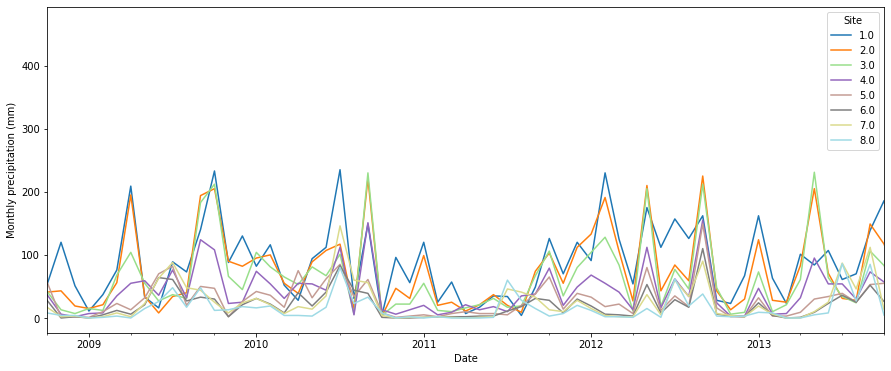

In [ ]:
#you can plot everything in a dataframe using name_of_dataframe.plot 
fig,ax =plt.subplots()
rainfall.plot(kind='line',figsize=(15,6),colormap='tab20',ax=ax)
ax.set_ylabel('Monthly precipitation (mm)')
plt.xlim(['2008-10-1','2013-10-1']) #we could zoom into a particular time period if we wanted by changing the axis limits 

# will plot PET if you donwloaded it
# fig,ax =plt.subplots()
# pet.plot(kind='line',figsize=(15,6),colormap='tab20',ax=ax)
# ax.set_ylabel('Monthly potential evapotranspiration (mm)')
# plt.xlim(['2008-10-1','2013-10-1']) #we could zoom into a particular time period if we wanted by changing the axis limits 


Here we have a time series with two different y-axes that share an x-axis

Text(0, 0.5, 'Monthly precipitation (mm)')

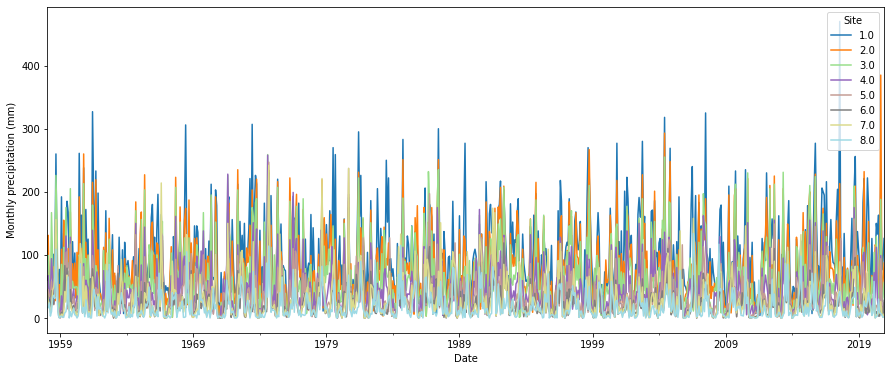

In [ ]:
# #you can plot everything in a dataframe using name_of_dataframe.plot 
fig,ax =plt.subplots(sharex=True)
rainfall.plot(kind='line',figsize=(15,6),colormap='tab20',ax=ax)
ax.set_ylabel('Monthly precipitation (mm)')


# # twin object for two different y-axis on the sample plot
# ax2=ax.twinx()

# # make a plot with different y-axis using second axis 
# pet.plot(kind='line',figsize=(15,6),colormap='tab20',ax=ax2,linestyle='dotted')
# ax2.set_ylabel('Monthly potential evapotranspiration (mm)')

# plt.xlim(['2012-10-1','2018-10-1']) #we could zoom into a particular time period if we wanted by changing the axis limits 


You could look at annual means and the mean annual rainfall for each site over the entire dataset

In [ ]:
# create a new dataframe that has annual precipitation listed by year by resampling to years and then summing over the whole year: 
freq = '1A' #1A is year 
annual_rainfall = rainfall.resample(freq).sum()

# compute the mean annual rainfall for each site 
mean_annual_rainfall = annual_rainfall.mean()

#compute standard deviation of annual rainfall for each site
stdev_annual_rainfall = annual_rainfall.std()

# You could also do a number of other computations on the data if you choose. 
# for example, you could create a dataframe with only Fall precip values by filtering for dates that have months 9, 10, or 11
fall_rainfall = rainfall.loc[rainfall.index.month.isin([9,10,11])].copy()


In [ ]:
#create a new dataframe to store the data
df_precip = pd.DataFrame({'Mean annual precipitation (mm)': mean_annual_rainfall,'Stdev annual precipitation (mm)': stdev_annual_rainfall})
df_precip['Site Name']=df_precip.index.astype(str)
df_elevs = pd.DataFrame({'Latitude':lats,'Longitude':lons,'Elevation (m)':els,'Site':ids})
df_elevs = df_elevs.set_index(['Site'])
df_elevs['Site Name'] = df_elevs.index.astype(str)

df = df_elevs.merge(df_precip,on='Site Name')

df.head()

,Latitude,Longitude,Elevation (m),Site Name,Mean annual precipitation (mm),Stdev annual precipitation (mm)
0,29.720000,-95.480000,27,1.0,1198.190476,246.332051
1,29.998571,-96.994286,90,2.0,965.793651,209.545296
2,30.277143,-98.508571,382,3.0,799.190476,178.627731
3,30.555714,-100.022857,639,4.0,576.587302,125.640120
4,30.834286,-101.537143,782,5.0,431.079365,114.987559


(38.0, 43.0)

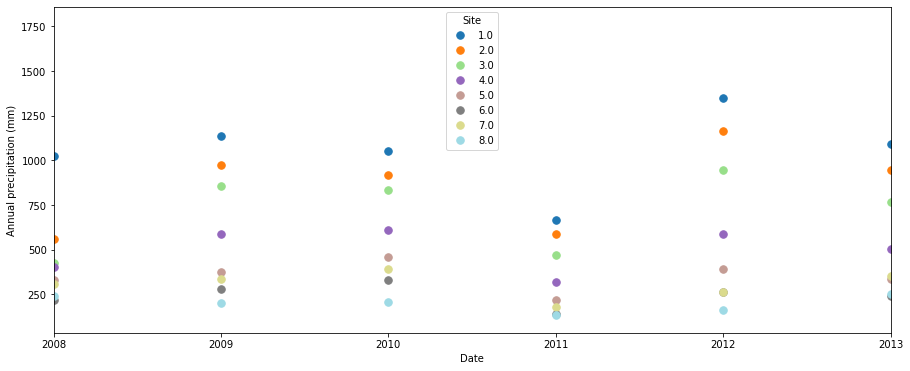

In [ ]:
fig,ax =plt.subplots(sharex=True)
annual_rainfall.plot(style='.',figsize=(15,6),markersize=15,colormap='tab20',ax=ax)
ax.set_ylabel('Annual precipitation (mm)')
plt.xlim(['2008-10-1','2013-10-1']) #we could zoom into a particular time period if we wanted by changing the axis limits 

# ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1) #this will put the legend on the outside of the plot 


[This command ](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_latex.html)will print a dataframe for you in LaTeX. Pretty cool! 


In [ ]:
print(df.to_latex(index=False))  

\begin{tabular}{rrrlrr}
\toprule
  Latitude &   Longitude &  Elevation (m) & Site Name &  Mean annual precipitation (mm) &  Stdev annual precipitation (mm) \\
\midrule
 29.720000 &  -95.480000 &             27 &       1.0 &                     1198.190476 &                       246.332051 \\
 29.998571 &  -96.994286 &             90 &       2.0 &                      965.793651 &                       209.545296 \\
 30.277143 &  -98.508571 &            382 &       3.0 &                      799.190476 &                       178.627731 \\
 30.555714 & -100.022857 &            639 &       4.0 &                      576.587302 &                       125.640120 \\
 30.834286 & -101.537143 &            782 &       5.0 &                      431.079365 &                       114.987559 \\
 31.112857 & -103.051429 &            836 &       6.0 &                      307.714286 &                        94.133130 \\
 31.391429 & -104.565714 &           1423 &       7.0 &                     

We could plot annual rainfall as a function of latitude, longitude or elevation

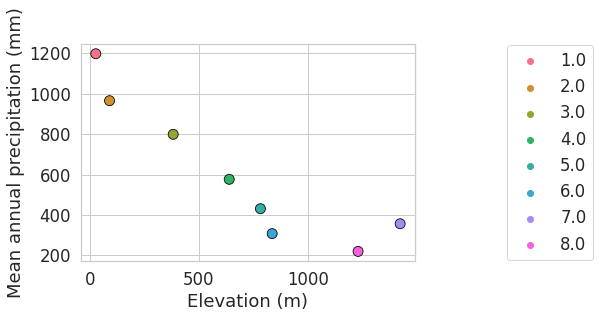

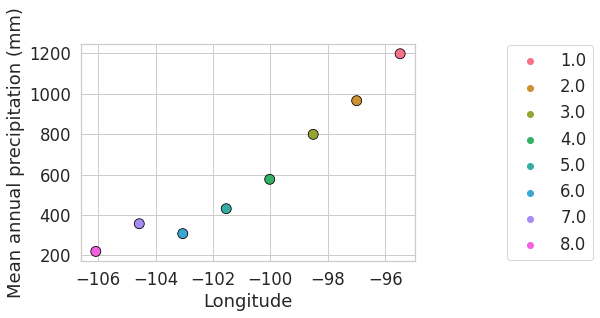

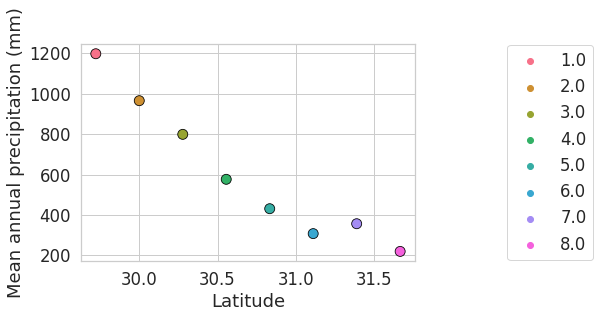

In [ ]:
#we can use a package called seaborn to plot dataframes. it makes pretty plots. 

import seaborn as sns #import seaborn

cmap = sns.color_palette("husl", n_colors= numsites) #sets the colormap 
sns.set(font_scale=1.5) #sets size of text 
sns.set_style("whitegrid") #sets the style of the plot


ax = sns.scatterplot(x='Elevation (m)',y='Mean annual precipitation (mm)',
                     hue="Site Name",s=100,
                     data=df,edgecolor='black',palette=cmap)

ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()



ax = sns.scatterplot(x='Longitude',y='Mean annual precipitation (mm)',
                     hue="Site Name",s=100,
                     data=df,edgecolor='black',palette=cmap)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()



ax = sns.scatterplot(x='Latitude',y='Mean annual precipitation (mm)',
                     hue="Site Name",s=100,
                     data=df,edgecolor='black',palette=cmap)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

# OPTIONAL: Take things a step further:

Studies report a number of expected changes in precipitation patterns in different regions across the world associated with warming. Can you come up with a collection of sites and analyze their precip data to evaluate these predictions or trends? 

For example, the recent Swain et al (2019) paper reports a number expected changes for California rainfall going into the future. Among those predictions is a sharpening of the wet season where fall and late spring precipitation decrease. Can we find any evidence of this? 

(733316.0, 735142.0)

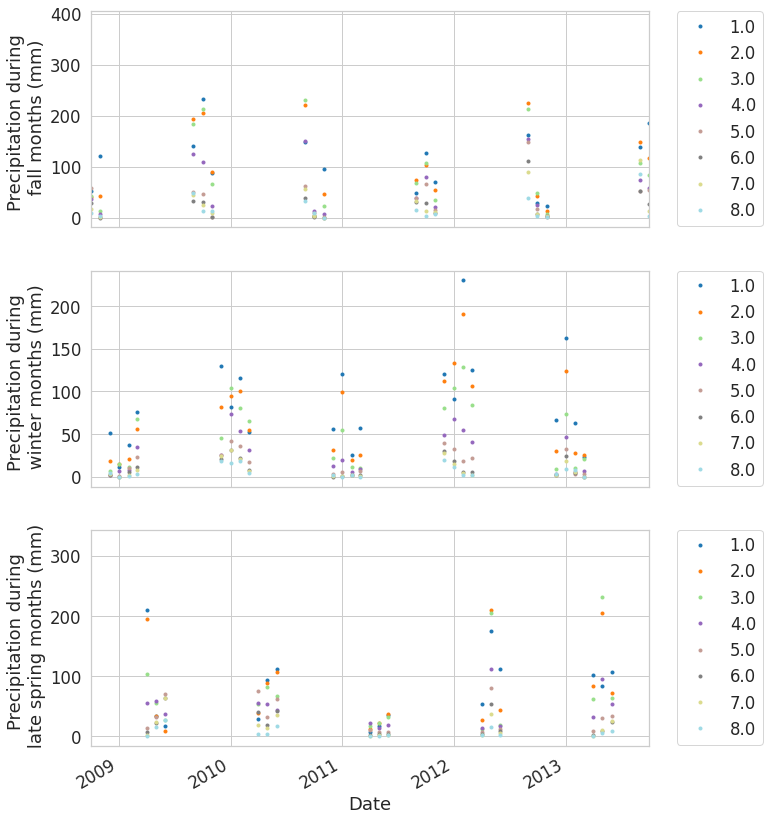

In [ ]:
# create a dataframe with only Fall precip values by filtering for dates that have months 9, 10, or 11
fall_rainfall = rainfall.loc[rainfall.index.month.isin([9,10,11])].copy()

fig,(ax1,ax2,ax3) =plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(10,15))
fall_rainfall.plot(style='.',colormap='tab20',ax=ax1)
ax1.set_ylabel('Precipitation during \n fall months (mm)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlim(['2008-10-1','2013-10-1']) #we could zoom into a particular time period if we wanted by changing the axis limits 

#we could do the same for winter and late spring
winter_rainfall = rainfall.loc[rainfall.index.month.isin([12,1,2,3])].copy()
winter_rainfall.plot(style='.',colormap='tab20',ax=ax2)
ax2.set_ylabel('Precipitation during \n winter months (mm)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlim(['2008-10-1','2013-10-1']) #we could zoom into a particular time period if we wanted by changing the axis limits 


late_spring_rainfall = rainfall.loc[rainfall.index.month.isin([4,5,6])].copy()
late_spring_rainfall.plot(style='.',colormap='tab20',ax=ax3)
ax3.set_ylabel('Precipitation during \n late spring months (mm)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(['2008-10-1','2013-10-1']) #we could zoom into a particular time period if we wanted by changing the axis limits 
